# Hash-Based Dimensionality Reduction for Online Machine Learning

### Initialization

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction import FeatureHasher
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import numpy as np
import numpy as np
import mmh3
from sklearn.datasets import fetch_20newsgroups
from sklearn.utils import shuffle


In [3]:
K_VALS = [2**i for i in range(7, 14)]       # Number of destination dimensions
C_VALS = [2, 4]                             # Number of hash functions for MFH

In [4]:
X, y = fetch_20newsgroups(subset='all', return_X_y=True)

In [5]:
vec = TfidfVectorizer(stop_words='english')

X_bow = vec.fit_transform(X)
feature_names = vec.get_feature_names_out()
N, D = X_bow.shape
print(f'Number of samples: {N}, number of features: {D}, number of classes: {len(np.unique(y))}')
print(f'Average number of non-zero features per sample: {X_bow.nnz / N:.5f}')

Number of samples: 18846, number of features: 173451, number of classes: 20
Average number of non-zero features per sample: 113.66205


### Baseline Model Predictions

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X_bow, y, test_size=0.2, random_state=42)

clf = KNeighborsClassifier()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
baseline_score = accuracy_score(y_test, y_pred)
print(f'Baseline accuracy: {baseline_score:.5f}')

Baseline accuracy: 0.81008


In [7]:
def dense_X(bow, feature_names):
    """
    Prepare feature matrix for hashing
    :param bow: Bag of words matrix
    :return: List of feature names and values
    """
    X = []
    for i in range(bow.shape[0]):
        row_indices = bow[i].indices
        row_values = bow[i].data
        row_vals = [(feature_names[j], row_values[idx]) for idx, j in enumerate(row_indices)]
        X.append(row_vals)
    return X

X_dense_bow = dense_X(X_bow, feature_names)

### Feature Hashing

In [8]:
fh_scores = []
for n_features in K_VALS:
    fh = FeatureHasher(n_features=n_features, input_type='pair')
    print(f'Hashing with {n_features} features')
    fh_hashed_X = fh.transform(X_dense_bow)
    X_train, X_test, y_train, y_test = train_test_split(fh_hashed_X, y, test_size=0.2, random_state=42)
    clf = KNeighborsClassifier()
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    score = accuracy_score(y_test, y_pred)
    fh_scores.append(score)

Hashing with 128 features
Hashing with 256 features
Hashing with 512 features
Hashing with 1024 features
Hashing with 2048 features
Hashing with 4096 features
Hashing with 8192 features


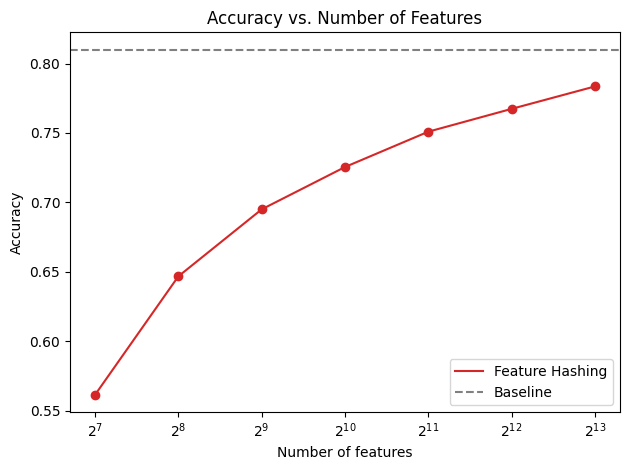

K         Accuracy  
128       0.56127   
256       0.64668   
512       0.69496   
1024      0.72546   
2048      0.75093   
4096      0.76737   
8192      0.78355   


In [9]:
fig, ax1 = plt.subplots()

ax1.set_title('Accuracy vs. Number of Features')
ax1.set_xlabel('Number of features')
ax1.set_ylabel('Accuracy')
ax1.plot(K_VALS, fh_scores, color='tab:red', label='Feature Hashing')
ax1.scatter(K_VALS, fh_scores, color='tab:red')
ax1.axhline(y=baseline_score, color='gray', linestyle='--', label='Baseline')
ax1.set_xscale('log', base=2)
ax1.legend()

plt.tight_layout()
plt.show()

print(f"{'K':<10}{'Accuracy':<10}")
for i, k in enumerate(K_VALS):
    print(f"{k:<10}{fh_scores[i]:<10.5f}")

### Multi Feature Hashing

In [10]:
class MultiFeatureHasher():
    def __init__(self, feature_names, max_hashes=1, seed=0):
        """
        Multi-feature hashing class that hashes multiple features into a fixed number of features.
        :param feature_names: List of feature names
        :param max_hashes: Maximum number of hashes to use
        :param seed: Base seed for hashing
        """
        self.feature_names = list(feature_names)
        self.signs = self._hash_signs(seed)
        self.hashes = np.array([self._hash_features(seed + i) for i in range(1, max_hashes + 1)])

    def _hash_signs(self, seed):
        """
        Generate random signs for hashing
        :param seed: Seed for random number generator
        :return: Array of random signs (-1 or 1)
        """
        np.random.seed(seed)
        return np.array(np.random.choice([-1, 1], size=len(self.feature_names)), dtype=np.int64)
    
    def _hash_features(self, seed):
        """
        Hash feature names
        :param seed: Seed for hashing
        :return: Array of hashed feature names
        """
        return np.array([mmh3.hash(f.encode('utf-8'), seed, signed=False) for f in self.feature_names], dtype=np.int64)
    
    def transform(self, X, n_features, n_hashes):
        """
        Hash feature matrix using multi-feature hashing
        :param X: List of feature names and values
        :param n_features: Number of features to hash to
        :param n_hashes: Number of hashes to use
        :return: Hashed feature matrix
        """
        X_hashed = np.zeros((len(X), n_features))
    
        for i, row in enumerate(X):
            row_features, row_values = zip(*row)
            feature_indices = np.searchsorted(feature_names, row_features)
            
            hs = self.hashes[:n_hashes][:, feature_indices] % n_features
            v = np.array(row_values) * self.signs[feature_indices] * np.sqrt(1 / n_hashes)
            
            for h in hs:
                np.add.at(X_hashed[i], h, v)

        return X_hashed

mfh = MultiFeatureHasher(feature_names, max_hashes=C_VALS[-1])

In [11]:
mfh_scores = []

for n_hashes in C_VALS:
    print(f'Hashing with {n_hashes} hashes')
    scores = []
    for n_features in K_VALS:
        print(f'Hashing with {n_features} features')
        mfh_hashed_X = mfh.transform(X_dense_bow, n_features, n_hashes)
        X_train, X_test, y_train, y_test = train_test_split(mfh_hashed_X, y, test_size=0.2, random_state=42)
        clf = KNeighborsClassifier()
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        score = accuracy_score(y_test, y_pred)
        scores.append(score)
    mfh_scores.append(scores)

Hashing with 2 hashes
Hashing with 128 features
Hashing with 256 features
Hashing with 512 features
Hashing with 1024 features
Hashing with 2048 features
Hashing with 4096 features
Hashing with 8192 features
Hashing with 4 hashes
Hashing with 128 features
Hashing with 256 features
Hashing with 512 features
Hashing with 1024 features
Hashing with 2048 features
Hashing with 4096 features
Hashing with 8192 features


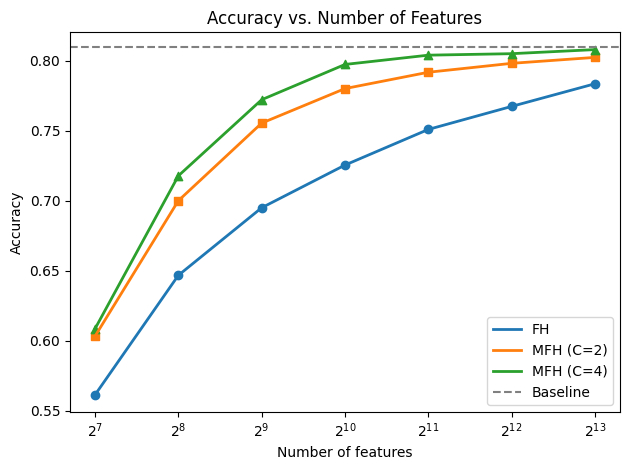

Accuracies:
K\C	FH	MFH2	MFH4
128	0.56127	0.60318	0.60849
256	0.64668	0.70000	0.71777
512	0.69496	0.75544	0.77215
1024	0.72546	0.78011	0.79735
2048	0.75093	0.79178	0.80398
4096	0.76737	0.79814	0.80504
8192	0.78355	0.80239	0.80796

In [12]:
import matplotlib.pyplot as plt

colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown']
markers = ['o', 's', '^', 'D', 'x', '*']

fig, ax1 = plt.subplots()

ax1.set_title('Accuracy vs. Number of Features')
ax1.set_xlabel('Number of features')
ax1.set_ylabel('Accuracy')
ax1.plot(K_VALS, fh_scores, color=colors[0], label='FH', linestyle='-', linewidth=2)
ax1.scatter(K_VALS, fh_scores, color=colors[0], marker=markers[0])
for i, scores in enumerate(mfh_scores):
    ax1.plot(K_VALS, scores, color=colors[(i+1) % len(colors)], label=f'MFH (C={C_VALS[i]})', linestyle='-', linewidth=2)
    ax1.scatter(K_VALS, scores, color=colors[(i+1) % len(colors)], marker=markers[(i+1) % len(markers)])
ax1.axhline(y=baseline_score, color='gray', linestyle='--', label='Baseline')
ax1.set_xscale('log', base=2)
ax1.legend()

plt.tight_layout()
plt.show()

print('Accuracies:')
print('K\\C\tFH', end='')
for C in C_VALS:
    print(f'\tMFH{C}', end='')
    
for i, K in enumerate(K_VALS):
    print(f'\n{K}', end='')
    print(f'\t{fh_scores[i]:.5f}', end='')
    for j, C in enumerate(C_VALS):
        print(f'\t{mfh_scores[j][i]:.5f}', end='')

### Cuckoo Hashing

In [ ]:
import numpy as np
import mmh3
from sklearn.neighbors import KNeighborsClassifier
from sklearn.calibration import LabelEncoder
from sklearn.utils import shuffle

class CuckooFeatureHasherNetwork:
    """
    Cuckoo Feature Hashing (CCFH) transformer and classifier.
    
    This class implements CCFH which addresses collisions in feature hashing
    by using a probabilistic mixture of two hash functions.
    
    Parameters:
    -----------
    feature_names : list
        List of all possible feature names.
    n_features : int
        Dimension of the projected feature space.
    q_ratio : float, default=0.2
        Ratio to determine dimension of q parameter.
    seed : int, default=0
        Random seed for reproducibility.
    clf : object, default=KNeighborsClassifier()
        Classifier to use for prediction.
    learning_rate : float, default=0.01
        Learning rate for gradient descent.
    epochs : int, default=10
        Number of training epochs.
    batch_size : int, default=256
        Batch size for training.
    l1 : float, default=0.1
        L1 regularization parameter.
    l2 : float, default=0.1
        L2 regularization parameter.
    momentum : float, default=0.9
        Momentum parameter for gradient descent.
    """
    def __init__(self, feature_names, n_features, q_ratio=0.2, learning_rate=0.01, epochs=10, batch_size=256, seed=0):
        self.feature_names = list(feature_names)
        self.feature_to_idx = {f: i for i, f in enumerate(feature_names)}
        self.n_features = n_features
        
        self.signs = self._hash_signs(seed)
        self.hashes_1 = self._hash_features(seed)
        self.hashes_2 = self._hash_features(seed + 1)
        self.hashes_H = self._hash_features(seed + 2)
        
        self.q_ratio = q_ratio
        self.dim_q = max(1, int(self.q_ratio * self.n_features))
        self.q = np.full(self.dim_q, 0.5)
        
        self.clf = KNeighborsClassifier()
        self._is_fitted = False
        
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.batch_size = batch_size
        
        self.label_encoder = LabelEncoder()

    def _hash_signs(self, seed):
        """Generate random signs (+1/-1) for features."""
        np.random.seed(seed)
        return np.array(np.random.choice([-1, 1], size=len(self.feature_names)), dtype=np.int64)
    
    def _hash_features(self, seed):
        """Hash feature names to integers."""
        return np.array([mmh3.hash(f.encode('utf-8'), seed, signed=False) 
                        for f in self.feature_names], dtype=np.int64)
    
    def _get_bucket_indices(self, feature_idx):
        """Get the bucket indices for a feature index."""
        h1 = self.hashes_1[feature_idx] % self.n_features
        h2 = self.hashes_2[feature_idx] % self.n_features
        H_idx = self.hashes_H[feature_idx] % self.dim_q
        s = self.signs[feature_idx]
        return h1, h2, H_idx, s
    
    def transform(self, X):
        """
        Transform samples using Cuckoo Feature Hashing.
        
        Parameters:
        -----------
        X : list of lists
            Each inner list contains tuples of (feature_name, value)
            
        Returns:
        --------
        transformed : numpy.ndarray
            Transformed feature vectors
        """
        n_samples = len(X)
        transformed = np.zeros((n_samples, self.n_features))
        
        for i, sample in enumerate(X):
            for feature, value in sample:
                if value == 0 or feature not in self.feature_to_idx:
                    continue
                idx = self.feature_to_idx[feature]
                h1, h2, H_idx, s = self._get_bucket_indices(idx)
                transformed[i, h1] += value * self.q[H_idx] * s
                transformed[i, h2] += value * (1 - self.q[H_idx]) * s
                
        return transformed
    
    def compute_loss_and_gradient(self, X, y):
        # CCFH transformation
        X_transformed = self.transform(X)
        y_encoded = self.label_encoder.transform(y)
        
        # Classifier training
        self.clf.fit(X_transformed, y_encoded)
        y_pred_proba = self.clf.predict_proba(X_transformed)
        
        # Loss computation
        loss = -np.sum(np.log(y_pred_proba[np.arange(len(y_encoded)), y_encoded]))
        loss /= len(y_encoded)
                
        # Gradient computation
        grad_q = np.zeros_like(self.q)
        for i, sample in enumerate(X):
            for feature, value in sample:
                if value == 0 or feature not in self.feature_to_idx:
                    continue
                idx = self.feature_to_idx[feature]
                h1, h2, H_idx, s = self._get_bucket_indices(idx)
                grad_q[H_idx] += value * s * (X_transformed[i, h1] - X_transformed[i, h2])
        grad_q /= len(y_encoded)
        
        return loss, grad_q
    
    def train(self, X, y):
        y = self.label_encoder.fit_transform(y)
        for epoch in range(self.epochs):
            epoch_loss = 0
            X, y = shuffle(X, y, random_state=0)
            for i in range(0, len(X), self.batch_size):
                X_batch = X[i:i+self.batch_size]
                y_batch = y[i:i+self.batch_size]
                loss, grad_q = self.compute_loss_and_gradient(X_batch, y_batch)
                self.q -= self.learning_rate * grad_q
                epoch_loss += loss
                
            print(f'Epoch {epoch+1}/{self.epochs} - Loss: {epoch_loss:.5f}')

        self._is_fitted = True
    
    def predict(self, X):
        if not self._is_fitted:
            raise ValueError("Model is not trained. Call train() first.")
        X_transformed = self.transform(X)
        return self.clf.predict(X_transformed)

In [6]:
import numpy as np
import mmh3
from sklearn.neighbors import KNeighborsClassifier
from sklearn.calibration import LabelEncoder
from sklearn.utils import shuffle

class CuckooFeatureHasherNetwork:
    """
    Cuckoo Feature Hashing (CCFH) transformer and classifier.
    
    This class implements CCFH which addresses collisions in feature hashing
    by using a probabilistic mixture of two hash functions.
    
    Parameters:
    -----------
    feature_names : list
        List of all possible feature names.
    n_features : int
        Dimension of the projected feature space.
    q_ratio : float, default=0.2
        Ratio to determine dimension of q parameter.
    seed : int, default=0
        Random seed for reproducibility.
    clf : object, default=KNeighborsClassifier()
        Classifier to use for prediction.
    learning_rate : float, default=0.01
        Learning rate for gradient descent.
    epochs : int, default=10
        Number of training epochs.
    batch_size : int, default=256
        Batch size for training.
    l1 : float, default=0.1
        L1 regularization parameter.
    l2 : float, default=0.1
        L2 regularization parameter.
    momentum : float, default=0.9
        Momentum parameter for gradient descent.
    """
    def __init__(self, feature_names, n_features, clf=KNeighborsClassifier(), q_ratio=0.2, seed=0,
                 learning_rate=0.001, epochs=10, batch_size=256, l1=0.1, l2=0.1, momentum=0.9):
        self.feature_names = list(feature_names)
        self.feature_to_idx = {f: i for i, f in enumerate(feature_names)}
        self.n_features = n_features
        
        self.seed = seed
        self.signs = self._hash_signs(seed)
        self.hashes_1 = self._hash_features(seed)
        self.hashes_2 = self._hash_features(seed + 1)
        self.hashes_H = self._hash_features(seed + 2)
        
        self.q_ratio = q_ratio
        self.dim_q = max(1, int(self.q_ratio * self.n_features))
        self.q = np.full(self.dim_q, 0.5)
        
        self.clf = clf
        self._is_fitted = False
        
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.batch_size = batch_size
        self.l1 = l1
        self.l2 = l2
        self.momentum = momentum
        
        self.velocity = np.zeros_like(self.q)
        
        self.label_encoder = LabelEncoder()

    def _hash_signs(self, seed):
        """Generate random signs (+1/-1) for features."""
        np.random.seed(seed)
        return np.array(np.random.choice([-1, 1], size=len(self.feature_names)), dtype=np.int64)
    
    def _hash_features(self, seed):
        """Hash feature names to integers."""
        return np.array([mmh3.hash(f.encode('utf-8'), seed, signed=False) 
                        for f in self.feature_names], dtype=np.int64)
    
    def _get_bucket_indices(self, feature_idx):
        """Get the bucket indices for a feature index."""
        h1 = self.hashes_1[feature_idx] % self.n_features
        h2 = self.hashes_2[feature_idx] % self.n_features
        H_idx = self.hashes_H[feature_idx] % self.dim_q
        s = self.signs[feature_idx]
        return h1, h2, H_idx, s
    
    def transform(self, X):
        """
        Transform samples using Cuckoo Feature Hashing.
        
        Parameters:
        -----------
        X : list of lists
            Each inner list contains tuples of (feature_name, value)
            
        Returns:
        --------
        transformed : numpy.ndarray
            Transformed feature vectors
        """
        n_samples = len(X)
        transformed = np.zeros((n_samples, self.n_features))
        
        for i, sample in enumerate(X):
            for feature, value in sample:
                if value == 0 or feature not in self.feature_to_idx:
                    continue
                idx = self.feature_to_idx[feature]
                h1, h2, H_idx, s = self._get_bucket_indices(idx)
                transformed[i, h1] += value * self.q[H_idx] * s
                transformed[i, h2] += value * (1 - self.q[H_idx]) * s
                
        return transformed
    
    def compute_loss_and_gradient(self, X, y):
        # CCFH transformation
        X_transformed = self.transform(X)
        y_encoded = self.label_encoder.transform(y)
        
        # Classifier training
        self.clf.fit(X_transformed, y_encoded)
        y_pred_proba = self.clf.predict_proba(X_transformed)
        
        # Loss computation
        loss = -np.sum(np.log(y_pred_proba[np.arange(len(y_encoded)), y_encoded])) / len(y_encoded)
        l1_penalty = self.l1 * np.sum(np.abs(self.q))
        l2_penalty = self.l2 * np.sum(self.q ** 2)
        loss += l1_penalty + l2_penalty
        
        # Gradient computation
        grad_q = np.zeros_like(self.q)
        for i, sample in enumerate(X):
            for feature, value in sample:
                if value == 0 or feature not in self.feature_to_idx:
                    continue
                idx = self.feature_to_idx[feature]
                h1, h2, H_idx, s = self._get_bucket_indices(idx)
                grad_q[H_idx] += value * s * (X_transformed[i, h1] - X_transformed[i, h2])
        grad_q += self.l1 * np.sign(self.q) + 2 * self.l2 * self.q
        grad_q /= len(y_encoded)
        
        return loss, grad_q
    
    def train(self, X, y):
        y = self.label_encoder.fit_transform(y)
        for epoch in range(self.epochs):
            X, y = shuffle(X, y, random_state=self.seed)
            
            for i in range(0, len(X), self.batch_size):
                X_batch = X[i:i + self.batch_size]
                y_batch = y[i:i + self.batch_size]
                
                loss, grad_q = self.compute_loss_and_gradient(X_batch, y_batch)
                
                self.velocity = self.momentum * self.velocity + self.learning_rate * grad_q
                self.q -= self.velocity
                self.q -= self.learning_rate * grad_q
                self.q = np.clip(self.q, 0, 1)
                
            print(f"Epoch {epoch + 1}/{self.epochs}, Loss: {loss:.5f}")
        
        X_transformed = self.transform(X)
        self.clf.fit(X_transformed, y_train)

        self._is_fitted = True
    
    def predict(self, X):
        if not self._is_fitted:
            raise ValueError("Model is not trained. Call train() first.")
        X_transformed = self.transform(X)
        return self.clf.predict(X_transformed)

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X_dense_bow, y, test_size=0.2, random_state=42)

cckh_scores = []

for n_features in K_VALS:
    print(f'Hashing with {n_features} features')
    cckh = CuckooFeatureHasherNetwork(feature_names, n_features)
    cckh.train(X_train, y_train)
    y_pred = cckh.predict(X_test)
    score = accuracy_score(y_test, y_pred)
    print(f'K={n_features}, Accuracy={score:.5f}')
    cckh_scores.append(score)

Hashing with 128 features
Epoch 1/10 - Loss: 80.29714
Epoch 2/10 - Loss: 79.69733
Epoch 3/10 - Loss: 79.51204
Epoch 4/10 - Loss: 79.89024
Epoch 5/10 - Loss: 79.60701
Epoch 6/10 - Loss: 79.84701
Epoch 7/10 - Loss: 79.96442
Epoch 8/10 - Loss: 79.68131
Epoch 9/10 - Loss: 79.86835
Epoch 10/10 - Loss: 79.52695
K=128, Accuracy=0.10955
Hashing with 256 features
Epoch 1/10 - Loss: 77.11264
Epoch 2/10 - Loss: 76.97110
Epoch 3/10 - Loss: 77.19553
Epoch 4/10 - Loss: 76.93455
Epoch 5/10 - Loss: 76.91665
Epoch 6/10 - Loss: 77.57262
Epoch 7/10 - Loss: 77.04344
Epoch 8/10 - Loss: 77.07593
Epoch 9/10 - Loss: 77.14316
Epoch 10/10 - Loss: 76.93021
K=256, Accuracy=0.13767
Hashing with 512 features
Epoch 1/10 - Loss: 73.83829
Epoch 2/10 - Loss: 73.36589
Epoch 3/10 - Loss: 73.48633
Epoch 4/10 - Loss: 73.30410
Epoch 5/10 - Loss: 73.37237
Epoch 6/10 - Loss: 73.50832
Epoch 7/10 - Loss: 73.25082
Epoch 8/10 - Loss: 73.03466
Epoch 9/10 - Loss: 73.39538
Epoch 10/10 - Loss: 73.14230
K=512, Accuracy=0.18462
Hashing

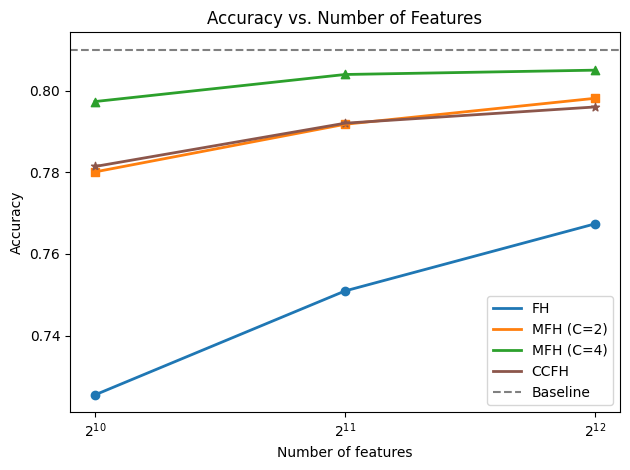

Accuracies:
K\C	FH	MFH2	MFH4	CCFH
1024	0.72546	0.78011	0.79735	0.78143
2048	0.75093	0.79178	0.80398	0.79204
4096	0.76737	0.79814	0.80504	0.79602


In [89]:
fig, ax1 = plt.subplots()

ax1.set_title('Accuracy vs. Number of Features')
ax1.set_xlabel('Number of features')
ax1.set_ylabel('Accuracy')
ax1.plot(K_VALS, fh_scores, color=colors[0], label='FH', linestyle='-', linewidth=2)
ax1.scatter(K_VALS, fh_scores, color=colors[0], marker=markers[0])
for i, scores in enumerate(mfh_scores):
    ax1.plot(K_VALS, scores, color=colors[(i+1) % len(colors)], label=f'MFH (C={C_VALS[i]})', linestyle='-', linewidth=2)
    ax1.scatter(K_VALS, scores, color=colors[(i+1) % len(colors)], marker=markers[(i+1) % len(markers)])
ax1.plot(K_VALS, cckh_scores, color=colors[-1], label='CCFH', linestyle='-', linewidth=2)
ax1.scatter(K_VALS, cckh_scores, color=colors[-1], marker=markers[-1])
ax1.axhline(y=baseline_score, color='gray', linestyle='--', label='Baseline')
ax1.set_xscale('log', base=2)
ax1.legend()

plt.tight_layout()
plt.show()

print('Accuracies:')
print('K\\C\tFH', end='')
for C in C_VALS:
    print(f'\tMFH{C}', end='')
print('\tCCFH')
for i, K in enumerate(K_VALS):
    print(f'{K}', end='')
    print(f'\t{fh_scores[i]:.5f}', end='')
    for j, C in enumerate(C_VALS):
        print(f'\t{mfh_scores[j][i]:.5f}', end='')
    print(f'\t{cckh_scores[i]:.5f}', end='')
    print()